In [1]:
import pickle

with open('data/SMRT/predictions_mean.pkl', 'rb') as file:
    preds = pickle.load(file)

In [2]:
import csv

inchi = {}
retention_time = {}
with open('data/SMRT/SMRT_dataset.csv') as file:
    reader = csv.reader(file, delimiter=';')
    next(reader) # toss headers
    for line in reader:
        inchi[line[0]] = line[2]
        retention_time[line[0]] = float(line[1])

In [3]:
key = '100053'
print(preds[key]['mean'])
print(retention_time[key])
print(inchi[key])

tensor([[ 1.0174e-03,  1.5513e-02,  7.7169e-02,  ..., -4.0345e-03,
          2.7410e-03, -2.2743e-03],
        [ 1.1307e-02,  1.8242e-02,  5.1028e-02,  ...,  1.5740e-03,
          9.8925e-04, -2.8439e-03],
        [-7.3048e-03,  1.8505e-02,  3.0558e-02,  ..., -1.2950e-03,
          1.6156e-03,  4.3451e-04],
        ...,
        [ 1.1715e-02,  1.1044e-01,  4.4743e-01,  ...,  1.7234e-06,
          2.4985e-04, -6.1138e-04],
        [ 2.7881e-02,  1.1070e-01,  4.0929e-01,  ...,  1.3172e-03,
         -5.1522e-04,  2.2020e-03],
        [ 1.3134e-02,  1.1317e-01,  3.9897e-01,  ...,  8.1963e-04,
          4.7869e-04,  2.0894e-03]])
82.9
InChI=1S/C10H14N6O3/c11-5-7(18)4(1-17)19-10(5)16-3-15-6-8(12)13-2-14-9(6)16/h2-5,7,10,17-18H,1,11H2,(H2,12,13,14)/t4-,5-,7+,10-/m1/s1


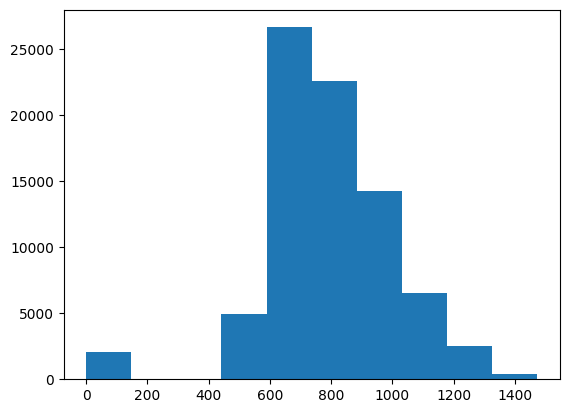

In [4]:
from matplotlib import pyplot as plt

plt.hist(list(retention_time.values()))
plt.show()

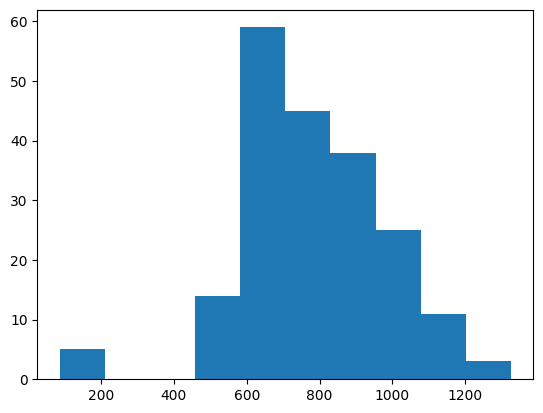

In [5]:
import random

random.seed(12345)

subset = random.sample(list(preds.keys()), 200)
plt.hist([retention_time[key] for key in subset])
plt.show()

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

mols = {}
fps = {}

fpgen = AllChem.GetRDKitFPGenerator()

for key in subset:
    mol = Chem.MolFromInchi(inchi[key])
    mols[key] = mol
    fps[key] = fpgen.GetFingerprint(mol)

In [7]:
# lets get pairwise

from rdkit import DataStructs

retention_diff = {}
tanimoto_sim = {}

sim_pairs = []

for i in range(len(subset)):
    for j in range(i+1, len(subset)):
        sim_pairs.append((subset[i], subset[j]))

for key in sim_pairs:
    retention_diff[key] = abs(retention_time[key[0]] - retention_time[key[1]])
    tanimoto_sim[key] = DataStructs.TanimotoSimilarity(fps[key[0]], fps[key[1]])

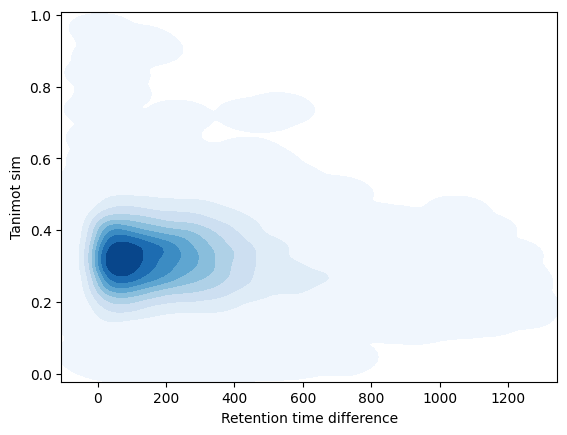

In [66]:
import seaborn as sns

x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(tanimoto_sim[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('Tanimot sim')
plt.xlabel('Retention time difference')
plt.show()

In [17]:
import ot
from tqdm import tqdm
import numpy as np

def calculate_gw_distance(cloud1, cloud2):
    C1_pts = cloud1.detach().cpu().numpy()
    C2_pts = cloud2.detach().cpu().numpy()
    
    # 2. Compute Geometry (Intra-structure Cost Matrices)
    # Gromov-Wasserstein compares the *relational* structure of points, 
    # so we need the pairwise distance matrix within each cloud.
    # ot.dist computes squared Euclidean distance by default.
    C1 = ot.dist(C1_pts, C1_pts, metric='euclidean')
    C2 = ot.dist(C2_pts, C2_pts, metric='euclidean')
    
    # 3. Normalize Cost Matrices (Recommended)
    # Normalizing by the max value helps with numerical stability and 
    # makes the comparison scale-invariant.
    C1 /= C1.max()
    C2 /= C2.max()
    
    # 4. Define Distributions
    # We assume uniform distribution (each point has equal weight)
    n_p = C1.shape[0]
    n_q = C2.shape[0]
    p = ot.unif(n_p)
    q = ot.unif(n_q)
    
    # 5. Calculate Gromov-Wasserstein Distance
    # gromov_wasserstein2 returns the log-distance (loss value)
    gw_dist = ot.gromov.gromov_wasserstein2(
        C1, 
        C2, 
        p, 
        q, 
        loss_fun='square_loss', # Option: 'kl_loss' or 'square_loss'
        verbose=False,
    )
    
    return 0.5 * np.sqrt(gw_dist)


gw_dist = {}

for key in tqdm(sim_pairs):
    gw_dist[key] = calculate_gw_distance(preds[key[0]]['mean'], preds[key[1]]['mean'])

100%|██████████| 19900/19900 [00:58<00:00, 341.18it/s]


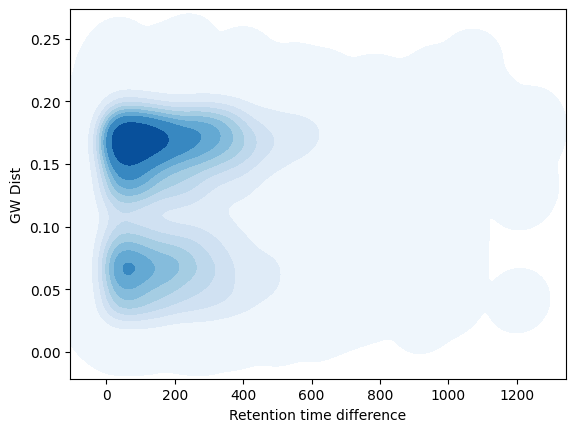

In [65]:
x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Retention time difference')
plt.show()

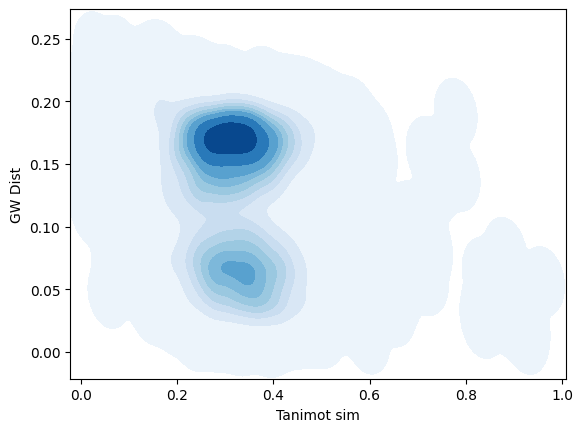

In [67]:
x = []
y = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Tanimot sim')
plt.show()

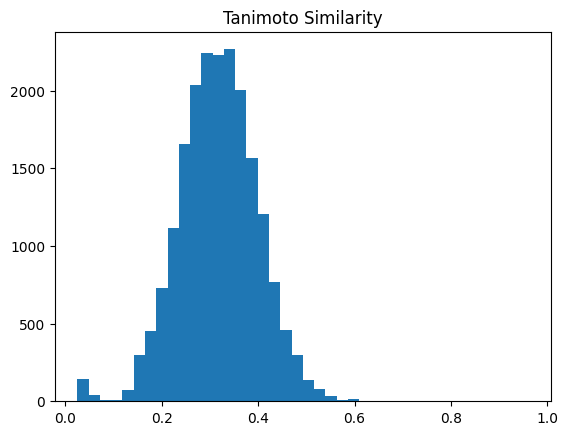

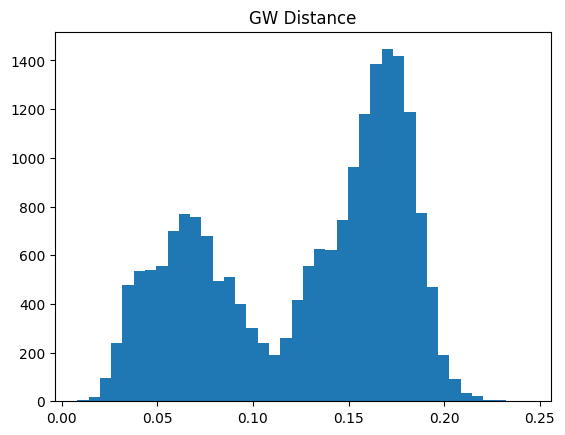

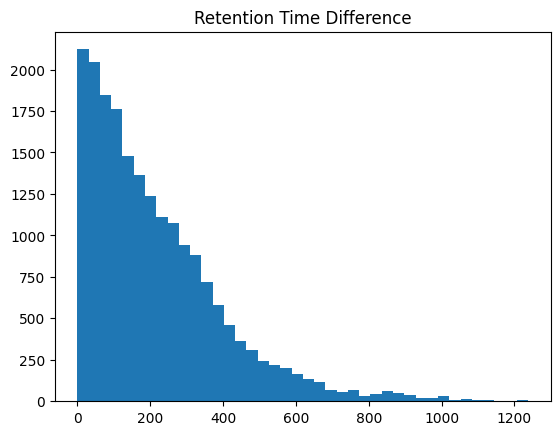

In [64]:
x = []
y = []
z = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])
    z.append(retention_diff[key])


plt.hist(x, bins=40)
plt.title('Tanimoto Similarity')
plt.show()
plt.hist(y, bins=40)
plt.title('GW Distance')
plt.show()
plt.hist(z, bins=40)
plt.title('Retention Time Difference')
plt.show()

In [21]:
with open('data/welQrate/AID435034/actives/preds.pkl', 'rb') as file:
    active_preds = pickle.load(file)

with open('data/welQrate/AID435034/inactives/preds.pkl', 'rb') as file:
    inactive_preds = pickle.load(file)

In [22]:
a_a_gw = []
i_i_gw = []
a_i_gw = []

active_keys = list(active_preds.keys())
inactive_keys = list(inactive_preds.keys())

for i in tqdm(range(len(active_keys))):
    for j in range(i+1, len(active_keys)):
        key1 = active_keys[i]
        key2 = active_keys[j]
        a_a_gw.append(calculate_gw_distance(active_preds[key1], active_preds[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(i+1, len(inactive_keys)):
        key1 = inactive_keys[i]
        key2 = inactive_keys[j]
        i_i_gw.append(calculate_gw_distance(inactive_preds[key1], inactive_preds[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(len(active_keys)):
        key1 = inactive_keys[i]
        key2 = active_keys[j]
        a_i_gw.append(calculate_gw_distance(inactive_preds[key1], active_preds[key2]))

100%|██████████| 1000/1000 [03:52<00:00,  4.29it/s]


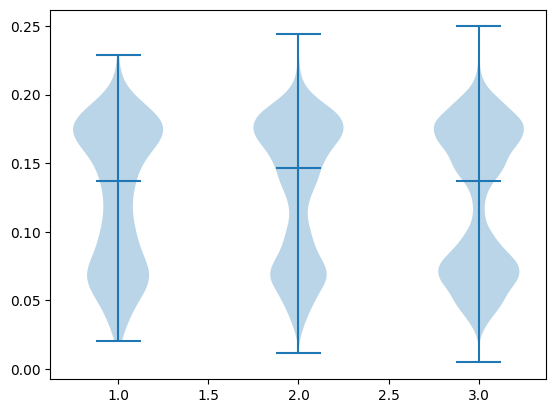

In [23]:
plt.violinplot([a_a_gw, a_i_gw, i_i_gw], showextrema=True, showmedians=True)
plt.show()

In [24]:
tani_gw_agreements = []
tani_gw_disagreements = []

for key in sim_pairs:
    if tanimoto_sim[key] > 0.8 and gw_dist[key] < 0.05:
        tani_gw_agreements.append(key)
    if tanimoto_sim[key] < 0.2 and gw_dist[key] < 0.05:
        tani_gw_disagreements.append(key)

print(len(tani_gw_agreements))
print(len(tani_gw_disagreements))

6
21


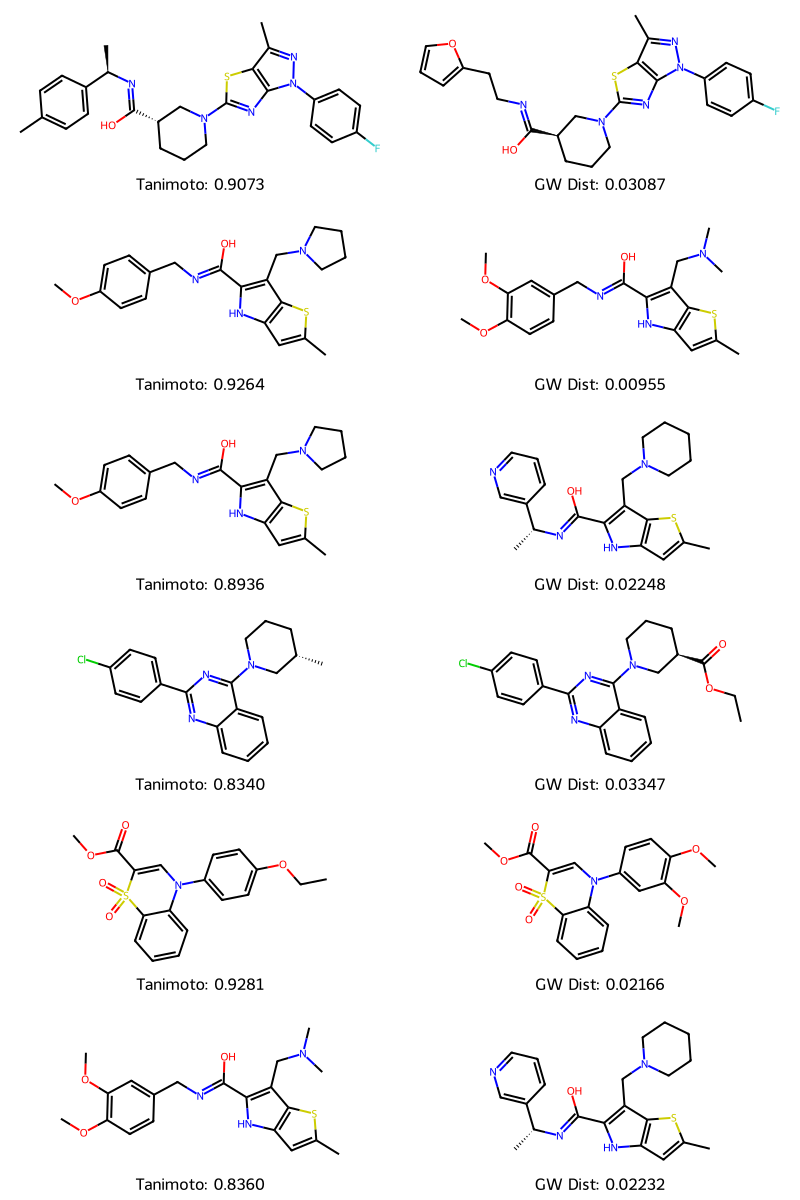

In [39]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

draw = []
leg = []
for key in tani_gw_agreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)


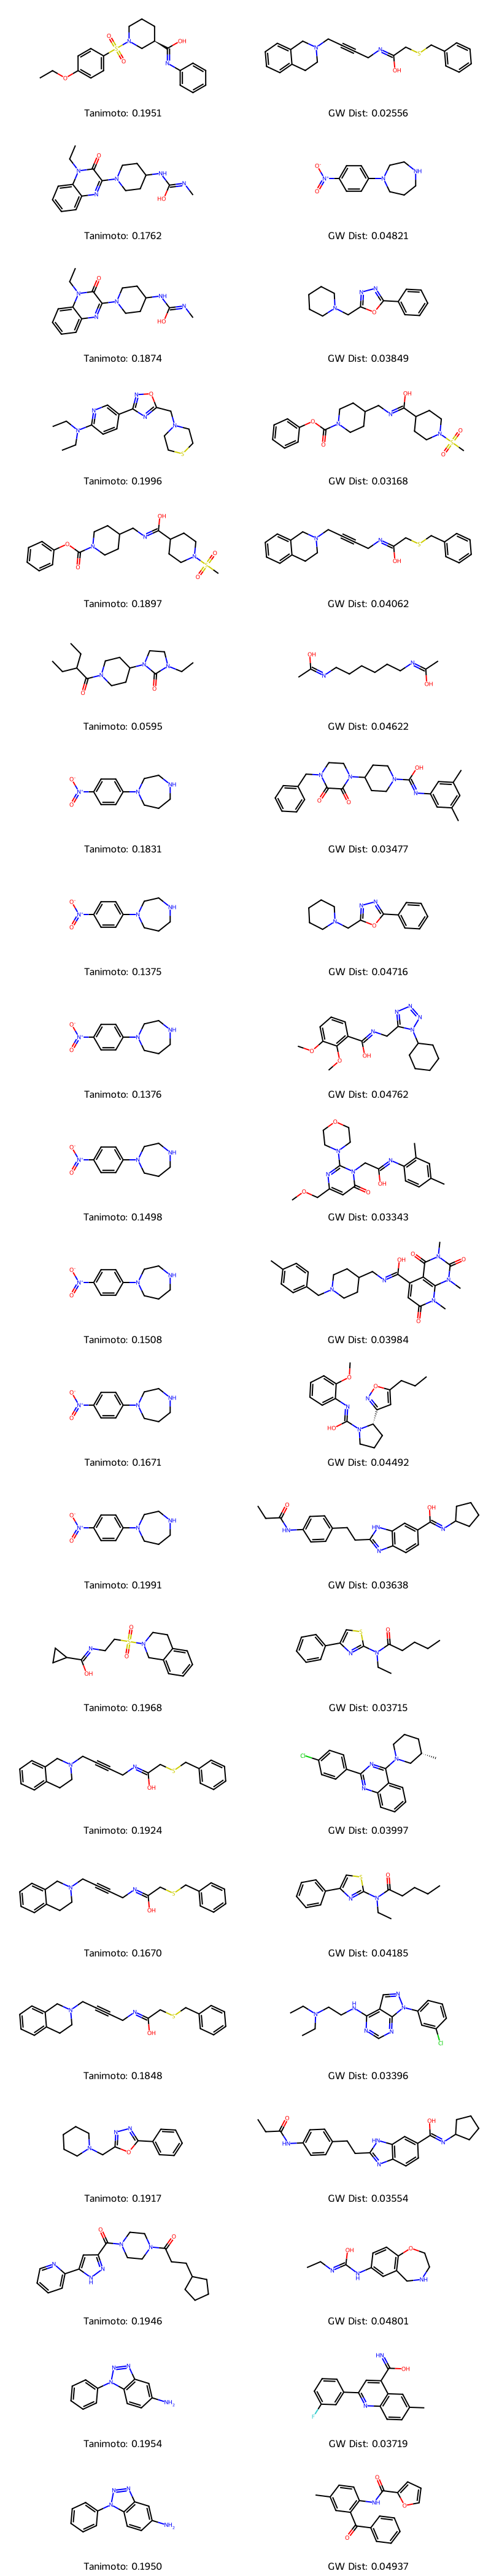

In [40]:
draw = []
leg = []
for key in tani_gw_disagreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)

In [42]:
with open('/home/iwe20/Projects/ElektroNN/elektronn/models/basisfunction_params.pkl', 'rb') as file:
    basis = pickle.load(file)

basis[1]

{'exp': tensor([15.6753,  3.6064,  1.2080,  0.4727,  0.2018,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0281,  2.0281,
          2.0281,  0.5359,  0.5359,  0.5359,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.2165,  2.2165,  2.2165,  2.2165,  2.2165,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.

In [68]:
basis.keys()

dict_keys([1.0, 6.0, 7.0, 8.0, 9.0, 16.0, 17.0])

In [58]:
import torch
torch.set_printoptions(sci_mode=False)
preds['3505']['mean'][0]

tensor([ 0.0105,  0.0065,  0.1022,  0.3974,  0.8817,  0.4079, -0.4220,  2.7948,
         5.3691, -0.4122, -0.9275,  4.2968,  3.5225,  0.7994, -0.0069, -0.0001,
        -0.0010,  0.0026, -0.0020,  0.0029, -0.0167,  0.0127, -0.0204, -0.0244,
         0.0148, -0.0255, -0.0138,  0.0072,  0.0077, -0.0063, -0.0002, -0.0016,
        -0.0082, -0.0078,  0.0063,  0.0026, -0.0018,  0.0017, -0.0024, -0.0074,
         0.0096,  0.0030, -0.0052,  0.0065, -0.0055, -0.0059,  0.0063,  0.0013,
        -0.0001, -0.0025, -0.0098,  0.0023, -0.0053,  0.0191,  0.0027,  0.0005,
        -0.0017,  0.0046, -0.0079,  0.0007, -0.0121,  0.0028,  0.0012, -0.0081,
        -0.0134, -0.0043,  0.0090, -0.0103,  0.0047,  0.0113,  0.0018, -0.0608,
         0.0340,  0.0429,  0.1045, -0.0069, -0.0672,  0.0391,  0.0321,  0.0840,
        -0.0108,  0.0190, -0.0201,  0.0052,  0.0095,  0.0021, -0.0076,  0.0010,
         0.0872, -0.0992,  0.0209,  0.0559,  0.0133, -0.0408,  0.0003,  0.0037,
         0.0042,  0.0043,  0.0015,  0.00

In [70]:
with open('/home/iwe20/Projects/ElektroNN/results.pkl', 'rb') as file:
    new_preds = pickle.load(file)

new_preds['3505'][0]

tensor([-0.0048, -0.0215,  0.0690,  0.1855,  0.5894,  0.8337,  0.2193, -0.2576,
         0.3535,  2.4001,  1.0514,  0.1149,  0.0000,  0.0000,  0.0189, -0.0053,
         0.0091,  0.0001, -0.0223,  0.0101, -0.0055, -0.0136,  0.0058,  0.0180,
         0.0091,  0.0085,  0.3320,  0.0443,  0.1457,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0049, -0.0097, -0.0116,  0.0011,  0.0010,  0.0129,  0.0070, -0.0072,
         0.0128, -0.0066,  0.0348,  0.0243,  0.0827, -0.0721, -0.0268, -0.1158,
         0.0454,  0.1005,  0.0208,  0.0613,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0040, -0.0198,  0.0060, -0.0033,  0.0173, -0.0052, -0.0164,
        -0.0091,  0.0085,  0.1053, -0.0578,  0.0847, -0.0738,  0.0441,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [ ]:
for key1 in new_preds:
    for key2 in new_preds:
        print(key1, key2, calculate_gw_distance(new_preds[key1], new_preds[key2]))

3505 3505 1.1307304090372935e-05
3505 1340 0.1889538590992109
3505 3344 0.17081913395811246
3505 2159 0.06744961595133656
1340 3505 0.18895385909921103
1340 1340 nan
1340 3344 0.14328217315518052
1340 2159 0.18585580875186572
3344 3505 0.17081913395811255
3344 1340 0.1432821731551802
3344 3344 7.498071165392474e-06
3344 2159 0.16211941285540393
2159 3505 0.0674496159513366
2159 1340 0.18585580875186553
2159 3344 0.16211941285540385
2159 2159 nan


/tmp/ipykernel_2352457/533654816.py:40: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * np.sqrt(gw_dist)


In [61]:
active_preds['1248737'][0]

tensor([ 0.0025,  0.0256,  0.0370,  0.1719,  0.5759,  0.8718,  0.3160, -0.2453,
         0.4058,  2.1828,  2.2553, -0.2321,  0.0000,  0.0000, -0.0013,  0.0088,
        -0.0091, -0.0012, -0.0081,  0.0038,  0.0080,  0.0036, -0.0006,  0.0368,
         0.0178, -0.0046,  0.1575, -0.0147,  0.0561,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0015, -0.0024,  0.0045, -0.0066,  0.0010,  0.0005, -0.0063,  0.0051,
        -0.0006,  0.0069,  0.0068, -0.0280,  0.0029,  0.0053,  0.0138,  0.0101,
        -0.0435,  0.0284, -0.0065,  0.0214,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0054,  0.0103,  0.0029, -0.0006, -0.0068,  0.0211,  0.0004,
         0.1086,  0.1110,  0.0538,  0.0271, -0.0918,  0.2805,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00